## Trying to get triplets closer to dispersion relation

In [87]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
sys.path.append("C:\\Users\josep\Downloads")

In [3]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [4]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [5]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [6]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

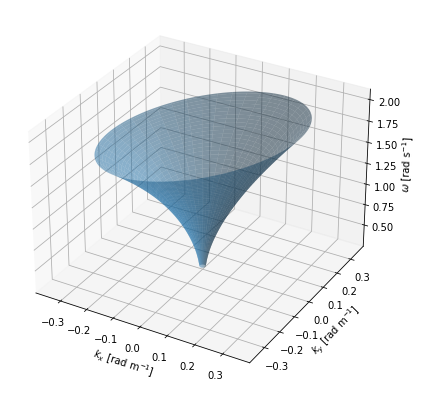

In [7]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=100, z = z, U = U, psi = 0)

In [8]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets')
    plt.plot(disp_r,disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta

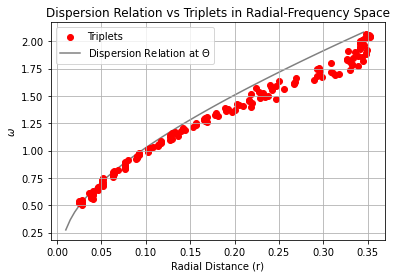

In [9]:
r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2.08, step_size = 0.01, h=100, 
                                                  z = z, U=U, psi = 0)

They are quite close - however they don't match too well for higher radial values/ higher frequencies

1.85 1.8483036778619946 353


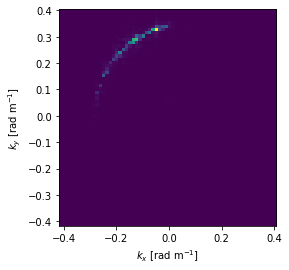

In [10]:
spec3d.plot_w_slice(1.85)
# Method for 3D, plot kx-ky spectra at a given w

In [11]:
at_w = 1.85
i = np.argmin(np.abs(spec3d.w[len(t)//2:]-at_w))
i

353

In [12]:
FFT_spec = spec3d.spectrum()
# 3d array

In [13]:
energies = FFT_spec[len(t)//2+i,:,:]

In [14]:
def find_indices_thresh(array, threshold):
    indices = []
    for i in range(len(array)):
        for j in range(len(array[i])):
            if array[i][j] > threshold:
                indices.append((i, j))
    return indices

In [15]:
indices = find_indices_thresh(energies, 0.01)
# threshold energy value 

In [16]:
kx_s = [index[0] for index in indices]
ky_s = [index[1] for index in indices]

In [17]:
spec3d.kx[kx_s]

array([-0.29194598, -0.29194598, -0.29194598, -0.29194598, -0.27925268,
       -0.27925268, -0.27925268, -0.27925268, -0.27925268, -0.27925268,
       -0.27925268, -0.27925268, -0.27925268, -0.26655938, -0.26655938,
       -0.26655938, -0.26655938, -0.25386607, -0.25386607, -0.25386607,
       -0.25386607, -0.25386607, -0.25386607, -0.25386607, -0.24117277,
       -0.24117277, -0.24117277, -0.24117277, -0.24117277, -0.22847947,
       -0.22847947, -0.22847947, -0.22847947, -0.22847947, -0.21578616,
       -0.21578616, -0.21578616, -0.21578616, -0.21578616, -0.21578616,
       -0.21578616, -0.20309286, -0.20309286, -0.20309286, -0.20309286,
       -0.20309286, -0.20309286, -0.20309286, -0.19039955, -0.19039955,
       -0.19039955, -0.19039955, -0.19039955, -0.17770625, -0.17770625,
       -0.17770625, -0.17770625, -0.17770625, -0.17770625, -0.16501295,
       -0.16501295, -0.16501295, -0.16501295, -0.16501295, -0.16501295,
       -0.16501295, -0.16501295, -0.15231964, -0.15231964, -0.15

In [18]:
spec3d.ky[ky_s]

array([ 0.        ,  0.02538661,  0.03807991,  0.05077321, -0.08885313,
       -0.05077321,  0.        ,  0.03807991,  0.05077321,  0.06346652,
        0.07615982,  0.08885313,  0.11423973,  0.08885313,  0.10154643,
        0.11423973,  0.16501295,  0.08885313,  0.13962634,  0.15231964,
        0.16501295,  0.17770625,  0.19039955,  0.20309286,  0.15231964,
        0.16501295,  0.17770625,  0.19039955,  0.20309286,  0.16501295,
        0.17770625,  0.19039955,  0.20309286,  0.22847947,  0.19039955,
        0.20309286,  0.21578616,  0.22847947,  0.24117277,  0.25386607,
        0.26655938,  0.19039955,  0.20309286,  0.21578616,  0.22847947,
        0.24117277,  0.25386607,  0.26655938,  0.21578616,  0.22847947,
        0.24117277,  0.26655938,  0.29194598,  0.20309286,  0.22847947,
        0.24117277,  0.25386607,  0.26655938,  0.29194598,  0.20309286,
        0.22847947,  0.24117277,  0.25386607,  0.26655938,  0.27925268,
        0.29194598,  0.30463929,  0.22847947,  0.25386607,  0.26

In [19]:
k_above_energy = np.sqrt( spec3d.kx[kx_s]**2 + spec3d.ky[ky_s]**2 )

In [20]:
k_above_energy

array([0.29194598, 0.29304767, 0.29441898, 0.29632816, 0.29304767,
       0.2838309 , 0.27925268, 0.28183708, 0.2838309 , 0.28637398,
       0.28945186, 0.29304767, 0.30171638, 0.28097825, 0.28524652,
       0.29000796, 0.31350147, 0.26896628, 0.28973004, 0.29605617,
       0.30278252, 0.30988303, 0.31733259, 0.3251072 , 0.28524652,
       0.2922218 , 0.29957272, 0.30727235, 0.31529512, 0.28183708,
       0.28945186, 0.29741361, 0.30569523, 0.32311876, 0.2877771 ,
       0.29632816, 0.30516772, 0.31427143, 0.32361702, 0.33318411,
       0.34295418, 0.27838588, 0.28721667, 0.29632816, 0.30569523,
       0.31529512, 0.3251072 , 0.33511283, 0.2877771 , 0.29741361,
       0.30727235, 0.32757578, 0.34854619, 0.26986334, 0.28945186,
       0.29957272, 0.30988303, 0.3203645 , 0.34177766, 0.26167916,
       0.28183708, 0.2922218 , 0.30278252, 0.31350147, 0.32436296,
       0.33535314, 0.34645976, 0.27459814, 0.29605617, 0.30701006,
       0.31809328, 0.32929277, 0.34059708, 0.24645938, 0.26776

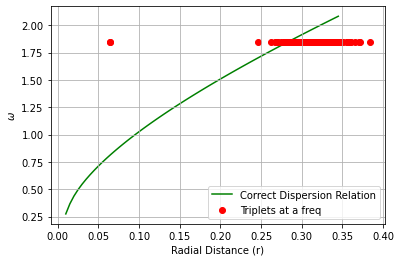

In [21]:
plt.plot(disp_r,disp_ww_for_theta, color='green',zorder=0, label = 'Correct Dispersion Relation')

plt.scatter(k_above_energy, np.full_like(k_above_energy, at_w), color = 'red', label = "Triplets at a freq")

plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.legend()

In [23]:
sum(k_above_energy)/len(k_above_energy)

0.31079126124584533

In [24]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [25]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [69]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
        
    return kx, ky, ww

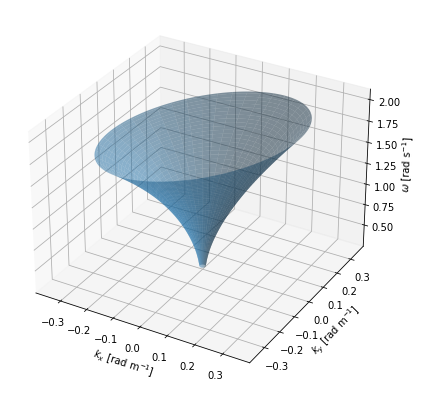

In [71]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=100, z = z, U = U, psi = 0)

In [72]:
disp_kx

array([[0.01      , 0.0099875 , 0.00995004, ..., 0.00996542, 0.00999449,
        0.00999859],
       [0.015     , 0.01498125, 0.01492506, ..., 0.01494813, 0.01499174,
        0.01499788],
       [0.02      , 0.01997501, 0.01990008, ..., 0.01993084, 0.01998899,
        0.01999717],
       ...,
       [0.335     , 0.33458134, 0.3333264 , ..., 0.3338416 , 0.33481556,
        0.33495264],
       [0.34      , 0.33957509, 0.33830142, ..., 0.33882431, 0.3398128 ,
        0.33995194],
       [0.345     , 0.34456884, 0.34327644, ..., 0.34380702, 0.34481005,
        0.34495123]])

In [73]:
def thing(spec_theta, h, z, U, psi = 0):
    

# (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.plot(disp_r, disp_ww_for_theta, color='red',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return disp_r,disp_ww_for_theta

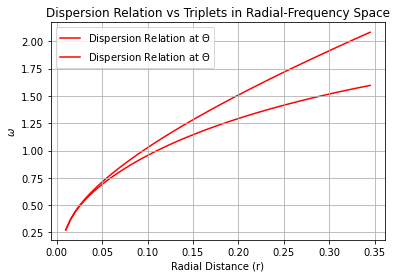

In [79]:
disp_r_0 , disp_ww_for_theta_0 = thing( 0 , h=100, z=z, U=U, psi = 0)
disp_r_pi , disp_ww_for_theta_pi = thing( np.pi , h=100, z=z, U=U, psi = 0)

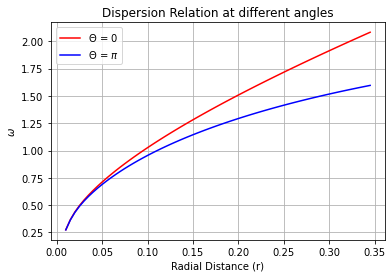

In [84]:
plt.plot(disp_r_0, disp_ww_for_theta_0, color='red', label = '$\Theta$ = 0')
plt.plot(disp_r_pi, disp_ww_for_theta_pi, color='blue', label = '$\Theta$ = $\pi$')

plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.title("Dispersion Relation at different angles")
plt.legend()

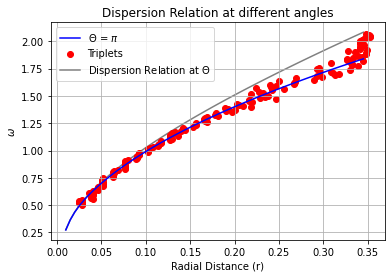

In [86]:
plt.plot(disp_r_pi, (disp_ww_for_theta_pi + disp_ww_for_theta_0)/2 , color='blue', label = '$\Theta$ = $\pi$')

r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2.08, step_size = 0.01, h=100, 
                                                  z = z, U=U, psi = 0)

plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.title("Dispersion Relation at different angles")
plt.legend()

In [75]:
disp_r, disp_ww_for_theta

(array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
        0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
        0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
        0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
        0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
        0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
        0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
        0.325, 0.33 , 0.335, 0.34 , 0.345]),
 array([0.27390735, 0.36619278, 0.43702509, 0.49510166, 0.54561073,
        0.59131099, 0.63367069, 0.67351859, 0.7113642 , 0.74754938,
        0.78232095, 0.81586702, 0.84833652, 0.87985055, 0.91050941,
        0.94039747, 0.96958647, 0.99813805, 1.0261056 , 1.05353569,
        1.08046925, 1.10694244, 1.13298737, 1.15863273, 1.18390424,
        1.20882506, 1.23341613, 1.25769647, 1.28168336, 1.30539263,
        1.32883875, 1.35203501, 1.37499366, 1.3977